In [1]:
from io import StringIO

import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import pydot_ng as pydot
from IPython.display import Image  

# Data Processing

In [2]:
# Load Data

df = pd.read_csv('./speed-dating-experiment/Speed Dating Data.csv', encoding="ISO-8859-1")

In [3]:
len(df)

8378

## Data Cleaning

In [4]:
STRING_COLUMNS = ['field', 'from', 'career', 'undergra']
COLUMNS_WITH_COMMA = ['income', 'zipcode', 'tuition', 'mn_sat']

In [5]:
# Clean Comma

for col in COLUMNS_WITH_COMMA:
    df[col] = df[col].replace('[,]', '', regex=True).astype(float)

In [6]:
# Drop Columns with String

df.drop(STRING_COLUMNS, axis=1, inplace=True)

In [7]:
# File NaN with 0

df.fillna(0, inplace=True)

## Split Data

In [8]:
X = np.array(df.drop('match', axis=1))
y = np.array(df['match'])

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

# KNN

In [10]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [11]:
pred = clf.predict(test_X)
accuracy_score(pred, test_y)

0.81205250596658707

# Decision Tree

In [12]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=5)
clf.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [13]:
pred = clf.predict(test_X)
accuracy_score(pred, test_y)

1.0

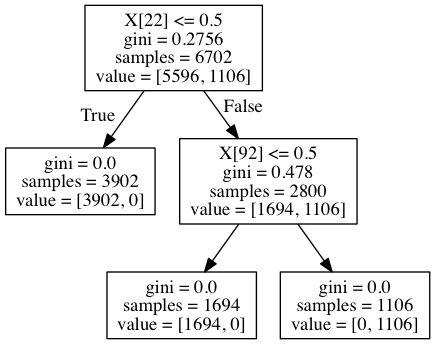

In [14]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  